In [1]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import BaseMessage, HumanMessage, ToolMessage

from langgraph.graph import StateGraph, END

from typing import (Annotated,Sequence,TypedDict)
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

from langchain_openai import AzureChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.tools import tool
import os
import json

tool 1: web search

In [2]:
# Initialize the Tavily search tool
search = TavilySearchResults()

@tool
def search_tool(query: str):
    """
    Search the web for information using Tavily API.

    :param query: The search query string
    :return: Search results related to the query
    """
    return search.invoke(query)

# Example usage
# uncomment the line below to test the search tool
# search_tool.invoke("What's the weather like in Tokyo today?")


tool 2: clothing recommendation

In [3]:
@tool
def recommend_clothing(weather: str) -> str:
    """
    Returns a clothing recommendation based on the provided weather description.

    This function examines the input string for specific keywords or temperature indicators 
    (e.g., "snow", "freezing", "rain", "85°F") to suggest appropriate attire. It handles 
    common weather conditions like snow, rain, heat, and cold by providing simple and practical 
    clothing advice.

    :param weather: A brief description of the weather (e.g., "Overcast, 64.9°F")
    :return: A string with clothing recommendations suitable for the weather
    """
    weather = weather.lower()
    if "snow" in weather or "freezing" in weather:
        return "Wear a heavy coat, gloves, and boots."
    elif "rain" in weather or "wet" in weather:
        return "Bring a raincoat and waterproof shoes."
    elif "hot" in weather or "85" in weather:
        return "T-shirt, shorts, and sunscreen recommended."
    elif "cold" in weather or "50" in weather:
        return "Wear a warm jacket or sweater."
    else:
        return "A light jacket should be fine."

tool registry

In [4]:
tools=[search_tool,recommend_clothing]

tools_by_name={ tool.name:tool for tool in tools}

AI model


In [5]:
# Configure ChatOpenAI for Azure OpenAI
deployment_name = "gpt-4o-mini"  # Replace with your actual deployment name

openai_llm = AzureChatOpenAI(
    azure_deployment=deployment_name,
    api_version=os.getenv("OPENAI_API_VERSION"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    temperature=0.7,
    model_name=deployment_name,
    max_retries=3,
    request_timeout=120,
    max_tokens=1024,
    top_p=0.95   
)


chat_prompt = ChatPromptTemplate.from_messages([
    ("system", """
You are a helpful AI assistant that thinks step-by-step and uses tools when needed.

When responding to queries:
1. First, think about what information you need
2. Use available tools if you need current data or specific capabilities  
3. Provide clear, helpful responses based on your reasoning and any tool results

Always explain your thinking process to help users understand your approach.
"""),
    MessagesPlaceholder(variable_name="scratch_pad")
])

# binding the tools to the LLM
model_react = chat_prompt | openai_llm.bind_tools(tools)

# Agent state:


class AgentState(TypedDict):
    """The state of the agent."""
    # add_messages is a reducer
    # See https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers
    messages: Annotated[Sequence[BaseMessage], add_messages]


# Example conversation flow:
state: AgentState = {"messages": []}

# append a message using the reducer properly
state["messages"] = add_messages(state["messages"], [HumanMessage(content="Hi")])
print("After greeting:", state["messages"])

# add another message (e.g. a question)
state["messages"] = add_messages(state["messages"], [HumanMessage(content="Weather in NYC?")])
print("After question:", (state))

After greeting: [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='32a9cfb6-bb1f-4c0d-8819-8d36b4368140')]
After question: {'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='32a9cfb6-bb1f-4c0d-8819-8d36b4368140'), HumanMessage(content='Weather in NYC?', additional_kwargs={}, response_metadata={}, id='8237ab8b-d47e-4441-9d7f-c62ea2aff694')]}


this is the ReAct manual execution, to understand the flow.

In [6]:
# 1. initial query processing
dummy_state: AgentState = {
    "messages": [HumanMessage( "What's the weather like in Zurich, and what should I wear based on the temperature?")]}

response = model_react.invoke({"scratch_pad":dummy_state["messages"]})
dummy_state["messages"]=add_messages(dummy_state["messages"],[response])


# 2. tool execution
tool_call = response.tool_calls[-1]
print("Tool call:", tool_call)

tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
print("Tool result preview:", tool_result[0]['title'])

tool_message = ToolMessage(
    content=json.dumps(tool_result),
    name=tool_call["name"],
    tool_call_id=tool_call["id"]
)
dummy_state["messages"] = add_messages(dummy_state["messages"], [tool_message])


# 3. processing Results and Next Action
response = model_react.invoke({"scratch_pad": dummy_state["messages"]})
dummy_state['messages'] = add_messages(dummy_state['messages'], [response])

# check if the model wants to use another tool
if response.tool_calls:
    tool_call = response.tool_calls[0]
    tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
    tool_message = ToolMessage(
        content=json.dumps(tool_result),
        name=tool_call["name"],
        tool_call_id=tool_call["id"]
    )
    dummy_state['messages'] = add_messages(dummy_state['messages'], [tool_message])


# 4. Final response generation
response = model_react.invoke({"scratch_pad": dummy_state["messages"]})
print("Final response generated:", response.content is not None)
print("More tools needed:", bool(response.tool_calls))

Tool call: {'name': 'search_tool', 'args': {'query': 'current weather in Zurich'}, 'id': 'call_SuO0Xp8hxsVMZ8kbzCAMyVtv', 'type': 'tool_call'}
Tool result preview: Zurich weather in September 2025 - Weather25.com
Final response generated: True
More tools needed: False


Now, let's automate ReAct with Graphs

In [7]:
# tool execution node
def tool_node(state: AgentState):
    """Execute all tool calls from the last message in the state."""
    outputs = []
    for tool_call in state["messages"][-1].tool_calls:
        tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
        outputs.append(
            ToolMessage(
                content=json.dumps(tool_result),
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outputs}


# model invocation node
def call_model(state: AgentState):
    """Invoke the model with the current conversation state."""
    response = model_react.invoke({"scratch_pad": state["messages"]})
    return {"messages": [response]}


# decision logic node
def should_continue(state: AgentState):
    """Determine whether to continue with tool use or end the conversation."""
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"

In [8]:
# creating the Graph:


# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Add edges between nodes
workflow.add_edge("tools", "agent")  # After tools, always go back to agent

# Add conditional logic
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "tools",  # If tools needed, go to tools node
        "end": END,          # If done, end the conversation
    },
)

# Set entry point
workflow.set_entry_point("agent")

# Compile the graph
graph = workflow.compile()

Running the Complete ReAct Agent

In [9]:
def print_stream(stream):
    """Helper function for formatting the stream nicely."""
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

inputs = {"messages": [HumanMessage(content="What's the weather like in Zurich, and what should I wear based on the temperature?")]}

print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

What's the weather like in Zurich, and what should I wear based on the temperature?
================================== Ai Message ==================================
Tool Calls:
  search_tool (call_rujFFNRgwfPaKTXLGiRWV7OZ)
 Call ID: call_rujFFNRgwfPaKTXLGiRWV7OZ
  Args:
    query: current weather in Zurich
================================= Tool Message =================================
Name: search_tool

[{"title": "Weather for Z\u00fcrich, Zurich, Switzerland - Time and Date", "url": "https://www.timeanddate.com/weather/switzerland/zurich", "content": "timeanddate.com\nFlag for Switzerland\n\n# Weather in Z\u00fcrich, Zurich, Switzerland\n\nPassing clouds.\n\nFeels Like: 76 \u00b0F  \nForecast: 77 / 55 \u00b0F  \nWind: 1 mph \u2191 from South\n\n|  |  |\n --- |\n| Location: | Zurich-Kloten |\n| Current Time: | Sep 20, 2025 at 9:02:20 pm |\n| Latest Report: | Sep 20, 2025 at 8:00 pm |\n| Visibility: | 19 

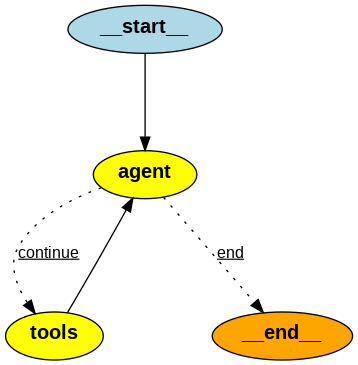

In [10]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_png()))